# Zadania - deep learning, projekt 2
Autorzy:
* Tomasz Ociepka tociepka@student.agh.edu.pl
* Szymon Lepianka slepianka@student.agh.edu.pl

**Import niezbędnych bibliotek**

In [1]:
import json
import os
import warnings
import IPython.display as ipd
import librosa
import matplotlib.pyplot as plt
import numpy as np

from keras.utils import np_utils
from scipy.io import wavfile
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

warnings.filterwarnings("ignore")

**Kaggle setup**

In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!touch /root/.kaggle/kaggle.json

api_token = {"username":"szymonlepianka","key":"486fdb332439db4439ff19ecc397b6ea"}

with open('/root/.kaggle/kaggle.json', 'w') as file:
  json.dump(api_token, file)

!chmod 600 /root/.kaggle/kaggle.json
! kaggle competitions download -c tensorflow-speech-recognition-challenge
! mkdir input
! 7z x train.7z -oinput -aoa

100% 501k/501k [00:08<00:00, 59.9kB/s]

100% 1.04G/1.04G [00:48<00:00, 25.9MB/s]
100% 1.04G/1.04G [00:48<00:00, 23.3MB/s]
100% 2.45G/2.46G [01:41<00:00, 40.5MB/s]
100% 2.46G/2.46G [01:41<00:00, 26.0MB/s]
  0% 0.00/50.0 [00:00<?, ?B/s]
100% 50.0/50.0 [00:00<00:00, 49.8kB/s]

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 39 - train/audio/_background_noise_/dude_miaowing.wav                                                            0% 41 - train/audio

In [3]:
os.listdir('./input/')

['train']

# Zadanie na dst

W oparciu o sieć głęboką z notatnika “Speech Recognition.ipynb” należy sprawdzić jak "skuteczność" klasyfikacji wybranych pięciu słów z bazy nagrań w języku angielskim zależy od liczebności zbioru treningowego.

Raport z zadania powinien prezentować (w formie graficznej/tabelarycznej) zarówno elementy macierzy pomyłek jak i wartości różnych parametrów używanych do mierzenia skuteczności klasyfikacji w przypadku klasyfikacji wieloklasowej.

**Dostępne słowa (labels) w bazie danych nagrań:**

In [4]:
train_audio_path = './input/train/audio/'

labels = os.listdir(train_audio_path)
labels


['three',
 'sheila',
 'off',
 'six',
 'eight',
 'dog',
 'happy',
 'two',
 'four',
 'seven',
 'one',
 'up',
 'bird',
 'five',
 'no',
 'yes',
 'down',
 'wow',
 'go',
 'tree',
 'left',
 'cat',
 'bed',
 'zero',
 'marvin',
 'house',
 '_background_noise_',
 'stop',
 'on',
 'nine',
 'right']

**Wybór pięciu słów spośród możliwych:**

In [5]:
labels = ["dog", "four", "go", "house", "right"]

**Długość nagrań**

A teraz sprawdźmy, jak długie są nagrania poleceń głosowych:

(array([  24.,   22.,   32.,   31.,  102.,   94.,  162.,  156.,  252.,
        9732.]),
 array([0.4586875 , 0.51281875, 0.56695   , 0.62108125, 0.6752125 ,
        0.72934375, 0.783475  , 0.83760625, 0.8917375 , 0.94586875,
        1.        ]),
 <a list of 10 Patch objects>)

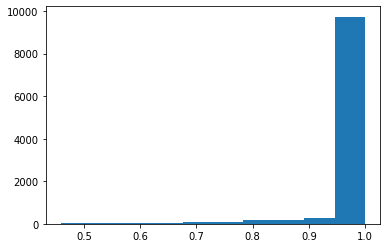

In [6]:
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings))

### **Preprocessing**

Widać, że w przypadku niektórych nagrań ich długość jest mniejsza, niż jedna sekunda oraz, że częstotliwość
próbkowania wynosi 16 tys Hz. Spośród wszystkich nagrań do dalszej pracy wybieramy tylko te z komendami zapisanymi
w tablicy labels. Wykonujemy resampling nagrań do częstotliwości 8 tys HZ i pozostawiamy tylko nagrania
jednosekundowe (złożone z 8000 próbek).


In [7]:
def data_preprocessing(labels):
    train_audio_path = './input/train/audio/'

    all_wave = []
    all_label = []
    for label in labels:
        print(label)
        waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
        for wav in waves:
            samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
            samples = librosa.resample(samples, sample_rate, 8000)
            if len(samples) == 8000:
                all_wave.append(samples)
                all_label.append(label)

    # Konwersja do kodów całkowitoliczbowych, wymaganych do treningu klasyfikatora:
    le = LabelEncoder()
    y = le.fit_transform(all_label) # X -> (X,), tyle jest pojedynczych przykładów, tablica int'ów
    classes = list(le.classes_)

    # Konwersja całkowitoliczbowych etykiet do jednego wektora:
    y = np_utils.to_categorical(y, num_classes=len(classes)) # (X,) -> (X, 10)

    # Przerabiamy macierze 2D na 3D, takiego wejścia spodziewa się sieć:
    all_wave = np.array(all_wave).reshape((-1, 8000, 1)) # (X,8000) -> (X, 8000, 1)

    return all_wave, y, classes

all_wave, y, classes = data_preprocessing(labels)

dog
four
go
house
right


Ilości próbek do odrzuceniu niepasujących:
* dog - 1547
* four - 2158
* go - 2101
* house - 1560
* right - 2155

**Wybór zbioru treningowego i walidacyjnego**

In [8]:
# wszystkich próbek x_tr jest 7616
x_trs = []
y_trs = []
numberOfTrainingElements = []
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=555, shuffle=True)
# próba 1:
# for i in (0.1,0.3,0.5,0.7,0.9,1):
#     x_trs.append(x_tr[0:int(len(x_tr)*i)])
#     y_trs.append(y_tr[0:int(len(y_tr)*i)])
#     numberOfTrainingElements.append(int(len(x_tr)*i))

# próba końcowa:
for i in range(0,22):
    x_trs.append(x_tr[0:500+(250*i)])
    y_trs.append(y_tr[0:500+(250*i)])
    numberOfTrainingElements.append((500+(250*i)))

print("Liczebność kolejnych zbiorów treningowych: ", numberOfTrainingElements)

Liczebność kolejnych zbiorów treningowych:  [500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750]


**Wybór architektury sieci dla problemu rozpozawaia komed głosowych**

Model speech-to-text zostanie zbudowany w oparciu o sieć conv1d. Conv1d to konwolucyjna sieć neuronowa, wykonująca konwolucję tylko w jedym wymiarze. 

**Budowa modelu**

Budujemy model korzystając z API frameworku Keras.

In [9]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

def getModel(): 
    K.clear_session()

    inputs = Input(shape=(8000,1))

    #First Conv1D layer
    conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Second Conv1D layer
    conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Third Conv1D layer
    conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Fourth Conv1D layer
    conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
    conv = MaxPooling1D(3)(conv)
    conv = Dropout(0.3)(conv)

    #Flatten layer
    conv = Flatten()(conv)

    #Dense Layer 1
    conv = Dense(256, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    #Dense Layer 2
    conv = Dense(128, activation='relu')(conv)
    conv = Dropout(0.3)(conv)

    outputs = Dense(len(labels), activation='softmax')(conv)

    model1 = Model(inputs, outputs)

    # "loss function" oparta o "categorical cross-entropy" - odpowiedni wybór dla problemu klasyfikacji wieloklasowej:
    model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # model.summary()
    return model1

Definiujemy funkcję, która znajduje wyraz odpowiadający sygnałowi audio::

In [10]:
def predictLabel(audio, model1):
    prob = model1.predict(audio.reshape(-1,8000,1))
    idx = np.argmax(prob[0])
    return idx

Rozmiar danych treningowych:  500
Epoch 1/80
16/16 [==============================] - 34s 70ms/step - loss: 1.6092 - accuracy: 0.2221 - val_loss: 1.6016 - val_accuracy: 0.2415

Epoch 00001: val_accuracy improved from -inf to 0.24147, saving model to ./best_model_500.hdf5
Epoch 2/80
16/16 [==============================] - 0s 24ms/step - loss: 1.5934 - accuracy: 0.3077 - val_loss: 1.5925 - val_accuracy: 0.2346

Epoch 00002: val_accuracy did not improve from 0.24147
Epoch 3/80
16/16 [==============================] - 0s 23ms/step - loss: 1.5738 - accuracy: 0.2750 - val_loss: 1.5791 - val_accuracy: 0.2462

Epoch 00003: val_accuracy improved from 0.24147 to 0.24619, saving model to ./best_model_500.hdf5
Epoch 4/80
16/16 [==============================] - 0s 23ms/step - loss: 1.5356 - accuracy: 0.2346 - val_loss: 1.5746 - val_accuracy: 0.2525

Epoch 00004: val_accuracy improved from 0.24619 to 0.25249, saving model to ./best_model_500.hdf5
Epoch 5/80
16/16 [==============================] -

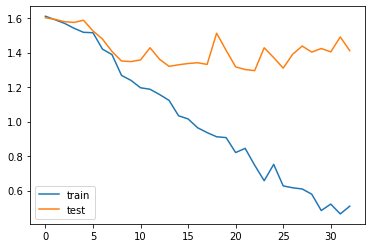

[[149  36  24  20  81]
 [ 16 345  40   6  25]
 [ 27 145 131  16 101]
 [  9  20  13 247  23]
 [ 43  74  51  46 217]]
              precision    recall  f1-score   support

           0       0.61      0.48      0.54       310
           1       0.56      0.80      0.66       432
           2       0.51      0.31      0.39       420
           3       0.74      0.79      0.76       312
           4       0.49      0.50      0.49       431

    accuracy                           0.57      1905
   macro avg       0.58      0.58      0.57      1905
weighted avg       0.57      0.57      0.56      1905

Rozmiar danych treningowych:  750
Epoch 1/80
24/24 [==============================] - 2s 35ms/step - loss: 1.6158 - accuracy: 0.1869 - val_loss: 1.6006 - val_accuracy: 0.2362

Epoch 00001: val_accuracy improved from -inf to 0.23622, saving model to ./best_model_750.hdf5
Epoch 2/80
24/24 [==============================] - 0s 19ms/step - loss: 1.5732 - accuracy: 0.2801 - val_loss: 1.5812 - val_

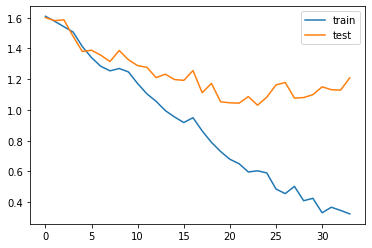

[[169  32  55  30  24]
 [ 13 365  33   6  15]
 [ 34  86 254  23  23]
 [ 12  15  32 242  11]
 [ 59  61  48  35 228]]
              precision    recall  f1-score   support

           0       0.59      0.55      0.57       310
           1       0.65      0.84      0.74       432
           2       0.60      0.60      0.60       420
           3       0.72      0.78      0.75       312
           4       0.76      0.53      0.62       431

    accuracy                           0.66      1905
   macro avg       0.66      0.66      0.66      1905
weighted avg       0.67      0.66      0.66      1905

Rozmiar danych treningowych:  1000
Epoch 1/80
32/32 [==============================] - 2s 27ms/step - loss: 1.6146 - accuracy: 0.2102 - val_loss: 1.5995 - val_accuracy: 0.2283

Epoch 00001: val_accuracy improved from -inf to 0.22835, saving model to ./best_model_1000.hdf5
Epoch 2/80
32/32 [==============================] - 0s 15ms/step - loss: 1.5775 - accuracy: 0.2580 - val_loss: 1.5802 - va

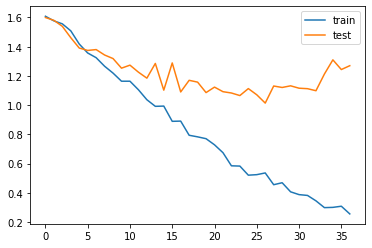

[[182  23  36   8  61]
 [ 13 364  27   3  25]
 [ 53 107 207  20  33]
 [ 17  10  19 243  23]
 [ 45  47  39  20 280]]
              precision    recall  f1-score   support

           0       0.59      0.59      0.59       310
           1       0.66      0.84      0.74       432
           2       0.63      0.49      0.55       420
           3       0.83      0.78      0.80       312
           4       0.66      0.65      0.66       431

    accuracy                           0.67      1905
   macro avg       0.67      0.67      0.67      1905
weighted avg       0.67      0.67      0.67      1905

Rozmiar danych treningowych:  1250
Epoch 1/80
40/40 [==============================] - 2s 23ms/step - loss: 1.5879 - accuracy: 0.2446 - val_loss: 1.5703 - val_accuracy: 0.2630

Epoch 00001: val_accuracy improved from -inf to 0.26299, saving model to ./best_model_1250.hdf5
Epoch 2/80
40/40 [==============================] - 1s 14ms/step - loss: 1.5491 - accuracy: 0.2442 - val_loss: 1.4981 - va

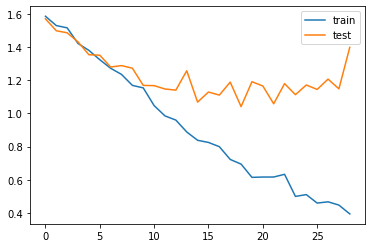

[[179  24  46  29  32]
 [ 13 321  67   7  24]
 [ 40 104 184  14  78]
 [  7   4   8 265  28]
 [ 21  34  95  40 241]]
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       310
           1       0.66      0.74      0.70       432
           2       0.46      0.44      0.45       420
           3       0.75      0.85      0.79       312
           4       0.60      0.56      0.58       431

    accuracy                           0.62      1905
   macro avg       0.63      0.63      0.63      1905
weighted avg       0.62      0.62      0.62      1905

Rozmiar danych treningowych:  1500
Epoch 1/80
47/47 [==============================] - 2s 22ms/step - loss: 1.5963 - accuracy: 0.2130 - val_loss: 1.5768 - val_accuracy: 0.2598

Epoch 00001: val_accuracy improved from -inf to 0.25984, saving model to ./best_model_1500.hdf5
Epoch 2/80
47/47 [==============================] - 1s 13ms/step - loss: 1.5344 - accuracy: 0.2683 - val_loss: 1.5433 - va

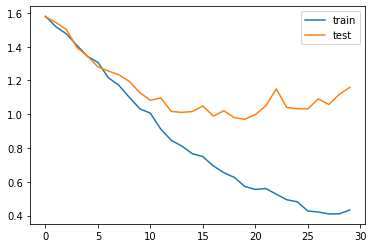

[[199  17  39  18  37]
 [ 18 369  27   2  16]
 [ 48 126 141   9  96]
 [ 27   3  11 248  23]
 [ 27  23  53  23 305]]
              precision    recall  f1-score   support

           0       0.62      0.64      0.63       310
           1       0.69      0.85      0.76       432
           2       0.52      0.34      0.41       420
           3       0.83      0.79      0.81       312
           4       0.64      0.71      0.67       431

    accuracy                           0.66      1905
   macro avg       0.66      0.67      0.66      1905
weighted avg       0.65      0.66      0.65      1905

Rozmiar danych treningowych:  1750
Epoch 1/80
55/55 [==============================] - 2s 19ms/step - loss: 1.5929 - accuracy: 0.2177 - val_loss: 1.5707 - val_accuracy: 0.2756

Epoch 00001: val_accuracy improved from -inf to 0.27559, saving model to ./best_model_1750.hdf5
Epoch 2/80
55/55 [==============================] - 1s 12ms/step - loss: 1.5317 - accuracy: 0.2616 - val_loss: 1.4677 - va

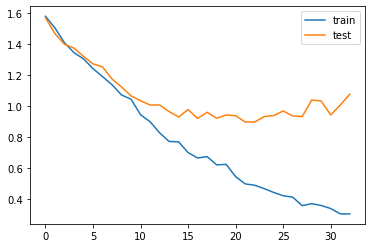

[[196  13  57  10  34]
 [ 14 326  78   0  14]
 [ 33  52 239   7  89]
 [ 14   3  13 251  31]
 [ 13   5  69  12 332]]
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       310
           1       0.82      0.75      0.78       432
           2       0.52      0.57      0.55       420
           3       0.90      0.80      0.85       312
           4       0.66      0.77      0.71       431

    accuracy                           0.71      1905
   macro avg       0.73      0.71      0.71      1905
weighted avg       0.72      0.71      0.71      1905

Rozmiar danych treningowych:  2000
Epoch 1/80
63/63 [==============================] - 2s 18ms/step - loss: 1.6072 - accuracy: 0.2214 - val_loss: 1.5890 - val_accuracy: 0.2467

Epoch 00001: val_accuracy improved from -inf to 0.24672, saving model to ./best_model_2000.hdf5
Epoch 2/80
63/63 [==============================] - 1s 11ms/step - loss: 1.5699 - accuracy: 0.2625 - val_loss: 1.4653 - va

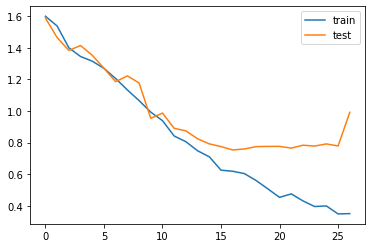

[[200  15  45  11  39]
 [ 14 371  36   5   6]
 [ 23  56 248  10  83]
 [  6   7  10 274  15]
 [ 13  14  61  20 323]]
              precision    recall  f1-score   support

           0       0.78      0.65      0.71       310
           1       0.80      0.86      0.83       432
           2       0.62      0.59      0.60       420
           3       0.86      0.88      0.87       312
           4       0.69      0.75      0.72       431

    accuracy                           0.74      1905
   macro avg       0.75      0.74      0.75      1905
weighted avg       0.74      0.74      0.74      1905

Rozmiar danych treningowych:  2250
Epoch 1/80
71/71 [==============================] - 2s 16ms/step - loss: 1.5972 - accuracy: 0.2421 - val_loss: 1.4966 - val_accuracy: 0.3050

Epoch 00001: val_accuracy improved from -inf to 0.30499, saving model to ./best_model_2250.hdf5
Epoch 2/80
71/71 [==============================] - 1s 11ms/step - loss: 1.4646 - accuracy: 0.3478 - val_loss: 1.3940 - va

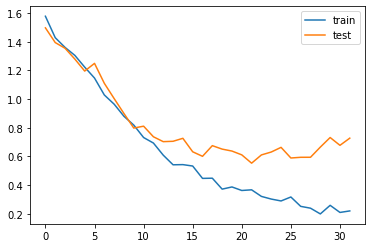

[[217   7  38  14  34]
 [ 10 353  48   2  19]
 [ 18  33 328  16  25]
 [  4   3  11 281  13]
 [  8  18  27   4 374]]
              precision    recall  f1-score   support

           0       0.84      0.70      0.77       310
           1       0.85      0.82      0.83       432
           2       0.73      0.78      0.75       420
           3       0.89      0.90      0.89       312
           4       0.80      0.87      0.83       431

    accuracy                           0.82      1905
   macro avg       0.82      0.81      0.82      1905
weighted avg       0.82      0.82      0.81      1905

Rozmiar danych treningowych:  2500
Epoch 1/80
79/79 [==============================] - 2s 16ms/step - loss: 1.6035 - accuracy: 0.2305 - val_loss: 1.5627 - val_accuracy: 0.2436

Epoch 00001: val_accuracy improved from -inf to 0.24357, saving model to ./best_model_2500.hdf5
Epoch 2/80
79/79 [==============================] - 1s 11ms/step - loss: 1.5251 - accuracy: 0.2644 - val_loss: 1.4185 - va

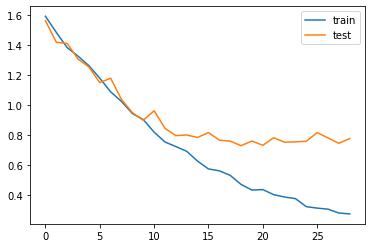

[[217  10  52   5  26]
 [  9 343  66   0  14]
 [ 21  40 296  10  53]
 [ 13   0  16 263  20]
 [ 20  11  59   6 335]]
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       310
           1       0.85      0.79      0.82       432
           2       0.61      0.70      0.65       420
           3       0.93      0.84      0.88       312
           4       0.75      0.78      0.76       431

    accuracy                           0.76      1905
   macro avg       0.78      0.76      0.77      1905
weighted avg       0.77      0.76      0.77      1905

Rozmiar danych treningowych:  2750
Epoch 1/80
86/86 [==============================] - 2s 15ms/step - loss: 1.5970 - accuracy: 0.2436 - val_loss: 1.5142 - val_accuracy: 0.3087

Epoch 00001: val_accuracy improved from -inf to 0.30866, saving model to ./best_model_2750.hdf5
Epoch 2/80
86/86 [==============================] - 1s 11ms/step - loss: 1.4806 - accuracy: 0.3002 - val_loss: 1.3700 - va

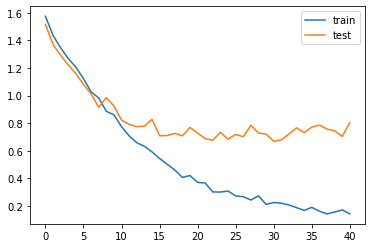

[[229  19  31   5  26]
 [  8 364  53   0   7]
 [ 20  23 343  11  23]
 [ 11   5  16 270  10]
 [ 28  10  33  11 349]]
              precision    recall  f1-score   support

           0       0.77      0.74      0.76       310
           1       0.86      0.84      0.85       432
           2       0.72      0.82      0.77       420
           3       0.91      0.87      0.89       312
           4       0.84      0.81      0.83       431

    accuracy                           0.82      1905
   macro avg       0.82      0.81      0.82      1905
weighted avg       0.82      0.82      0.82      1905

Rozmiar danych treningowych:  3000
Epoch 1/80
94/94 [==============================] - 2s 14ms/step - loss: 1.6008 - accuracy: 0.2388 - val_loss: 1.5470 - val_accuracy: 0.2751

Epoch 00001: val_accuracy improved from -inf to 0.27507, saving model to ./best_model_3000.hdf5
Epoch 2/80
94/94 [==============================] - 1s 10ms/step - loss: 1.4696 - accuracy: 0.3059 - val_loss: 1.3860 - va

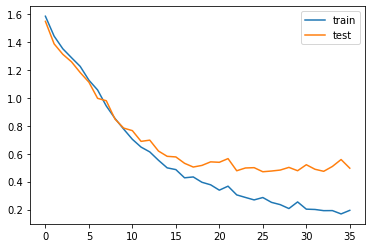

[[248   4  27  12  19]
 [ 16 364  36   0  16]
 [ 28  22 342  11  17]
 [  7   6   6 287   6]
 [  8   5  14   3 401]]
              precision    recall  f1-score   support

           0       0.81      0.80      0.80       310
           1       0.91      0.84      0.87       432
           2       0.80      0.81      0.81       420
           3       0.92      0.92      0.92       312
           4       0.87      0.93      0.90       431

    accuracy                           0.86      1905
   macro avg       0.86      0.86      0.86      1905
weighted avg       0.86      0.86      0.86      1905

Rozmiar danych treningowych:  3250
Epoch 1/80
102/102 [==============================] - 2s 14ms/step - loss: 1.5881 - accuracy: 0.2434 - val_loss: 1.4737 - val_accuracy: 0.2824

Epoch 00001: val_accuracy improved from -inf to 0.28241, saving model to ./best_model_3250.hdf5
Epoch 2/80
102/102 [==============================] - 1s 10ms/step - loss: 1.4413 - accuracy: 0.3377 - val_loss: 1.3914 

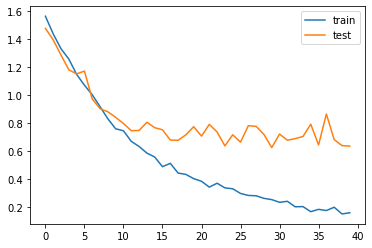

[[246   3  29   8  24]
 [ 15 341  64   0  12]
 [ 32  16 320  11  41]
 [  8   2  12 278  12]
 [ 24   4  28   4 371]]
              precision    recall  f1-score   support

           0       0.76      0.79      0.77       310
           1       0.93      0.79      0.85       432
           2       0.71      0.76      0.73       420
           3       0.92      0.89      0.91       312
           4       0.81      0.86      0.83       431

    accuracy                           0.82      1905
   macro avg       0.83      0.82      0.82      1905
weighted avg       0.82      0.82      0.82      1905

Rozmiar danych treningowych:  3500
Epoch 1/80
110/110 [==============================] - 2s 13ms/step - loss: 1.5808 - accuracy: 0.2537 - val_loss: 1.4946 - val_accuracy: 0.3045

Epoch 00001: val_accuracy improved from -inf to 0.30446, saving model to ./best_model_3500.hdf5
Epoch 2/80
110/110 [==============================] - 1s 10ms/step - loss: 1.4037 - accuracy: 0.3645 - val_loss: 1.4103 

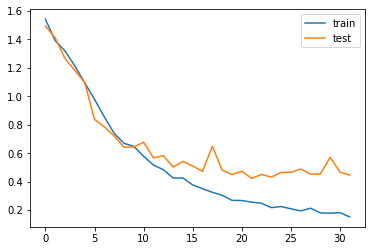

[[258   5  26   4  17]
 [ 11 380  27   1  13]
 [ 32  13 348  10  17]
 [  8   4   5 290   5]
 [ 16   7  17   4 387]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       310
           1       0.93      0.88      0.90       432
           2       0.82      0.83      0.83       420
           3       0.94      0.93      0.93       312
           4       0.88      0.90      0.89       431

    accuracy                           0.87      1905
   macro avg       0.87      0.87      0.87      1905
weighted avg       0.87      0.87      0.87      1905

Rozmiar danych treningowych:  3750
Epoch 1/80
118/118 [==============================] - 2s 13ms/step - loss: 1.5873 - accuracy: 0.2395 - val_loss: 1.4290 - val_accuracy: 0.3669

Epoch 00001: val_accuracy improved from -inf to 0.36693, saving model to ./best_model_3750.hdf5
Epoch 2/80
118/118 [==============================] - 1s 10ms/step - loss: 1.4283 - accuracy: 0.3638 - val_loss: 1.4192 

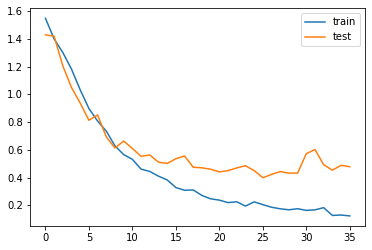

[[257   9  24   6  14]
 [ 10 384  22   3  13]
 [ 20  16 364   7  13]
 [  3   4   6 295   4]
 [ 11   5  24   7 384]]
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       310
           1       0.92      0.89      0.90       432
           2       0.83      0.87      0.85       420
           3       0.93      0.95      0.94       312
           4       0.90      0.89      0.89       431

    accuracy                           0.88      1905
   macro avg       0.88      0.88      0.88      1905
weighted avg       0.88      0.88      0.88      1905

Rozmiar danych treningowych:  4000
Epoch 1/80
125/125 [==============================] - 2s 12ms/step - loss: 1.5791 - accuracy: 0.2350 - val_loss: 1.3734 - val_accuracy: 0.4226

Epoch 00001: val_accuracy improved from -inf to 0.42257, saving model to ./best_model_4000.hdf5
Epoch 2/80
125/125 [==============================] - 1s 10ms/step - loss: 1.3898 - accuracy: 0.3819 - val_loss: 1.3335 

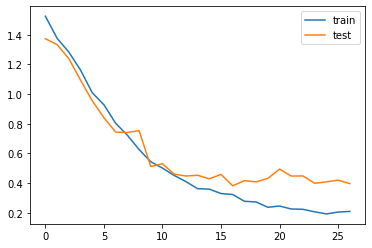

[[256  16  24   9   5]
 [  8 388  20   3  13]
 [ 17  34 336  16  17]
 [  8   3   8 290   3]
 [  7  18   9   4 393]]
              precision    recall  f1-score   support

           0       0.86      0.83      0.84       310
           1       0.85      0.90      0.87       432
           2       0.85      0.80      0.82       420
           3       0.90      0.93      0.91       312
           4       0.91      0.91      0.91       431

    accuracy                           0.87      1905
   macro avg       0.87      0.87      0.87      1905
weighted avg       0.87      0.87      0.87      1905

Rozmiar danych treningowych:  4250
Epoch 1/80
133/133 [==============================] - 2s 13ms/step - loss: 1.5864 - accuracy: 0.2466 - val_loss: 1.4029 - val_accuracy: 0.3832

Epoch 00001: val_accuracy improved from -inf to 0.38320, saving model to ./best_model_4250.hdf5
Epoch 2/80
133/133 [==============================] - 1s 10ms/step - loss: 1.4072 - accuracy: 0.3610 - val_loss: 1.3095 

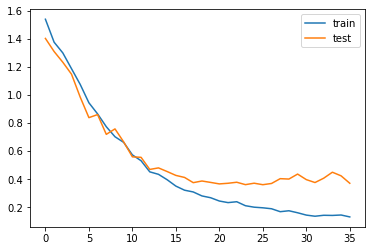

[[249  11  32  11   7]
 [  3 390  23   2  14]
 [ 11  19 366  13  11]
 [  4   1   6 298   3]
 [  5   6  12   8 400]]
              precision    recall  f1-score   support

           0       0.92      0.80      0.86       310
           1       0.91      0.90      0.91       432
           2       0.83      0.87      0.85       420
           3       0.90      0.96      0.93       312
           4       0.92      0.93      0.92       431

    accuracy                           0.89      1905
   macro avg       0.90      0.89      0.89      1905
weighted avg       0.89      0.89      0.89      1905

Rozmiar danych treningowych:  4500
Epoch 1/80
141/141 [==============================] - 2s 12ms/step - loss: 1.5790 - accuracy: 0.2466 - val_loss: 1.3883 - val_accuracy: 0.3617

Epoch 00001: val_accuracy improved from -inf to 0.36168, saving model to ./best_model_4500.hdf5
Epoch 2/80
141/141 [==============================] - 1s 10ms/step - loss: 1.3996 - accuracy: 0.3839 - val_loss: 1.2995 

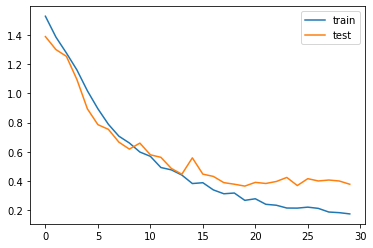

[[249   7  32   5  17]
 [  8 373  33   2  16]
 [ 13  14 359  16  18]
 [  2   3   4 298   5]
 [  4   4  13   9 401]]
              precision    recall  f1-score   support

           0       0.90      0.80      0.85       310
           1       0.93      0.86      0.90       432
           2       0.81      0.85      0.83       420
           3       0.90      0.96      0.93       312
           4       0.88      0.93      0.90       431

    accuracy                           0.88      1905
   macro avg       0.89      0.88      0.88      1905
weighted avg       0.88      0.88      0.88      1905

Rozmiar danych treningowych:  4750
Epoch 1/80
149/149 [==============================] - 2s 11ms/step - loss: 1.5700 - accuracy: 0.2652 - val_loss: 1.4033 - val_accuracy: 0.3696

Epoch 00001: val_accuracy improved from -inf to 0.36955, saving model to ./best_model_4750.hdf5
Epoch 2/80
149/149 [==============================] - 1s 10ms/step - loss: 1.3980 - accuracy: 0.3697 - val_loss: 1.2932 

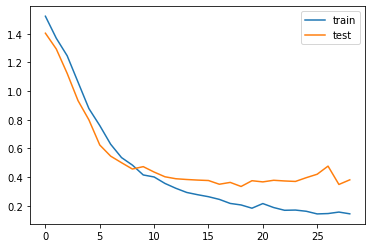

[[264   8  30   6   2]
 [  5 392  16   4  15]
 [ 13  23 358  12  14]
 [  6   5   8 292   1]
 [  6   8   8   5 404]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.87       310
           1       0.90      0.91      0.90       432
           2       0.85      0.85      0.85       420
           3       0.92      0.94      0.93       312
           4       0.93      0.94      0.93       431

    accuracy                           0.90      1905
   macro avg       0.90      0.90      0.90      1905
weighted avg       0.90      0.90      0.90      1905

Rozmiar danych treningowych:  5000
Epoch 1/80
157/157 [==============================] - 3s 11ms/step - loss: 1.5754 - accuracy: 0.2548 - val_loss: 1.4281 - val_accuracy: 0.3601

Epoch 00001: val_accuracy improved from -inf to 0.36010, saving model to ./best_model_5000.hdf5
Epoch 2/80
157/157 [==============================] - 1s 9ms/step - loss: 1.3672 - accuracy: 0.4063 - val_loss: 1.2418 -

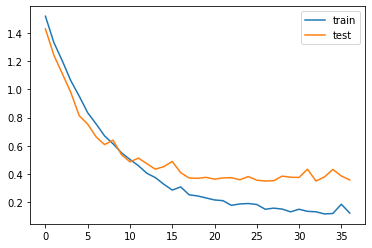

[[268   3  26   6   7]
 [ 10 390  16   3  13]
 [ 14  20 365  11  10]
 [  6   3   6 292   5]
 [  9  11  11   4 396]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.87       310
           1       0.91      0.90      0.91       432
           2       0.86      0.87      0.86       420
           3       0.92      0.94      0.93       312
           4       0.92      0.92      0.92       431

    accuracy                           0.90      1905
   macro avg       0.90      0.90      0.90      1905
weighted avg       0.90      0.90      0.90      1905

Rozmiar danych treningowych:  5250
Epoch 1/80
165/165 [==============================] - 3s 11ms/step - loss: 1.5828 - accuracy: 0.2512 - val_loss: 1.4066 - val_accuracy: 0.3669

Epoch 00001: val_accuracy improved from -inf to 0.36693, saving model to ./best_model_5250.hdf5
Epoch 2/80
165/165 [==============================] - 2s 10ms/step - loss: 1.3976 - accuracy: 0.3732 - val_loss: 1.2969 

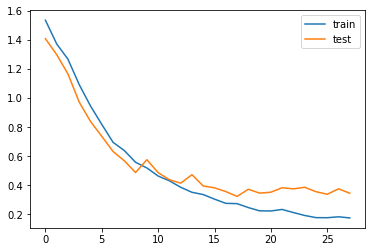

[[265   6  24   9   6]
 [ 11 370  33   8  10]
 [ 16  12 367  15  10]
 [  3   1   5 298   5]
 [  4   2  16  14 395]]
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       310
           1       0.95      0.86      0.90       432
           2       0.82      0.87      0.85       420
           3       0.87      0.96      0.91       312
           4       0.93      0.92      0.92       431

    accuracy                           0.89      1905
   macro avg       0.89      0.89      0.89      1905
weighted avg       0.89      0.89      0.89      1905

Rozmiar danych treningowych:  5500
Epoch 1/80
172/172 [==============================] - 3s 11ms/step - loss: 1.5457 - accuracy: 0.2614 - val_loss: 1.3444 - val_accuracy: 0.4142

Epoch 00001: val_accuracy improved from -inf to 0.41417, saving model to ./best_model_5500.hdf5
Epoch 2/80
172/172 [==============================] - 2s 9ms/step - loss: 1.3626 - accuracy: 0.4071 - val_loss: 1.2719 -

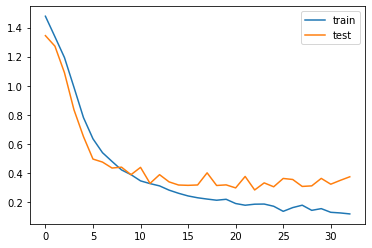

[[266   5  26   8   5]
 [  7 395  16   3  11]
 [ 16  15 373   7   9]
 [  3   2   6 298   3]
 [  5   6  15   2 403]]
              precision    recall  f1-score   support

           0       0.90      0.86      0.88       310
           1       0.93      0.91      0.92       432
           2       0.86      0.89      0.87       420
           3       0.94      0.96      0.95       312
           4       0.94      0.94      0.94       431

    accuracy                           0.91      1905
   macro avg       0.91      0.91      0.91      1905
weighted avg       0.91      0.91      0.91      1905

Rozmiar danych treningowych:  5750
Epoch 1/80
180/180 [==============================] - 3s 13ms/step - loss: 1.5630 - accuracy: 0.2619 - val_loss: 1.4414 - val_accuracy: 0.3501

Epoch 00001: val_accuracy improved from -inf to 0.35013, saving model to ./best_model_5750.hdf5
Epoch 2/80
180/180 [==============================] - 2s 9ms/step - loss: 1.3528 - accuracy: 0.4079 - val_loss: 1.1872 -

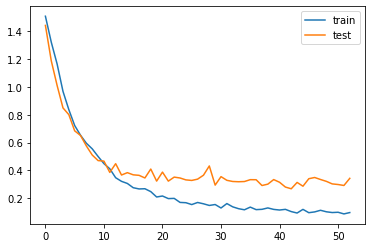

[[272   5  18  10   5]
 [ 10 388  17   6  11]
 [ 16  13 379   8   4]
 [  3   3   3 302   1]
 [  7   5   9   6 404]]
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       310
           1       0.94      0.90      0.92       432
           2       0.89      0.90      0.90       420
           3       0.91      0.97      0.94       312
           4       0.95      0.94      0.94       431

    accuracy                           0.92      1905
   macro avg       0.91      0.92      0.92      1905
weighted avg       0.92      0.92      0.92      1905



In [11]:
y_val_pop = [np.argmax(y) for y in y_val] # cyfry od 1 do 5

accuracyScores = []
for i in range(len(x_trs)):
    print("Rozmiar danych treningowych: ", len(x_trs[i]))
    model = getModel()

    # callback'i użyte w celu zatrzymania treningu sieci neuronowej w odpowiednim momencie
    # (zanim zacznie się przetrenowanie)
    # i w celu zapisania najlepszego uzyskanego modelu uzyskanego po każdej z epok treningu:
    metric = 'val_accuracy'
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
    mc = ModelCheckpoint("./best_model_"+str(numberOfTrainingElements[i])+".hdf5", monitor=metric, verbose=1, save_best_only=True, mode='max')

    # Trening i testowaie na zbiorze walidacyjnym:
    history=model.fit(x_trs[i], y_trs[i] ,epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

    # Wykres diagnostyczny"
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()

    # Ładujemy najlepszy zapamiętany model:
    model=load_model("best_model_"+str(numberOfTrainingElements[i])+".hdf5")

    predicted = [predictLabel(x, model) for x in x_val]

    cm = confusion_matrix(y_val_pop, predicted)
    print(cm)
    print(classification_report(y_val_pop, predicted))
    accuracyScores.append(accuracy_score(y_val_pop, predicted))

Wykres *accuracyScores* z zależności od liczby elementów zbioru testowego:

[500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 4500, 4750, 5000, 5250, 5500, 5750]
[0.5716535433070866, 0.6603674540682415, 0.6698162729658793, 0.6246719160104987, 0.6624671916010498, 0.705511811023622, 0.7433070866141732, 0.8152230971128609, 0.763254593175853, 0.8162729658792651, 0.8619422572178478, 0.8167979002624672, 0.8729658792650918, 0.883989501312336, 0.8729658792650918, 0.8939632545931758, 0.8818897637795275, 0.8976377952755905, 0.8981627296587926, 0.889763779527559, 0.910761154855643, 0.916010498687664]


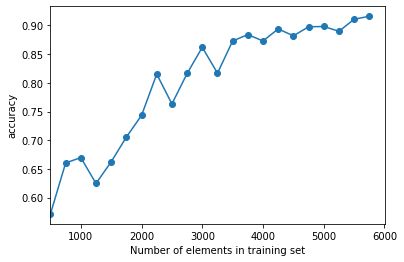

Najlepszy wynik uzyskano dla zbioru treningowego o liczebności:  5750


In [17]:
def printAccuracyPlot(numberOfTrainingElements1, accuracyScores1):
    print(numberOfTrainingElements)
    print(accuracyScores)
    plt.plot(numberOfTrainingElements1, accuracyScores1,'-o')
    plt.xlim(left=numberOfTrainingElements1[0])
    plt.xlabel("Number of elements in training set")
    plt.ylabel("accuracy")
    plt.show()

printAccuracyPlot(numberOfTrainingElements, accuracyScores)

best_model_number = numberOfTrainingElements[np.argmax(accuracyScores)]
print("Najlepszy wynik uzyskano dla zbioru treningowego o liczebności: ", best_model_number)

## Wnioski do zadania na dst:

Pierwsze wykonaliśmy próbę z kilkami modelami z całego zakresu możliwej ilości danych. Wyniki próby:

Liczebność zbioru treningowego z całego możliwego zakresu.

In [ ]:
numberOfTrainingElements = [761, 2284, 3808, 5331, 6854, 7616]

**Uzyskane rezulaty:**

[761, 2284, 3808, 5331, 6854, 7616]
[0.6110236220472441, 0.7564304461942257, 0.884514435695538, 0.8908136482939633, 0.9128608923884515, 0.9165354330708662]


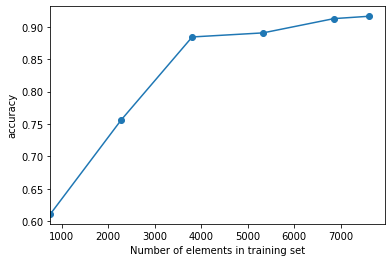

In [ ]:
accuracyScores = [0.6110236220472441, 0.7564304461942257, 0.884514435695538, 0.8908136482939633, 0.9128608923884515, 0.9165354330708662]
printAccuracyPlot(numberOfTrainingElements, accuracyScores)

**Wniosek:**
do około 3000 *accuracy* rośnie liniowo, od około 4000 rośnie bardzo powoli (asymptotycznie).

**Rezultaty finalnej próby**

Zakres danych [500, 5750]. Zbiór treningowy zwiększany za każdym razem o 250 próbek. 

Wykres accuracyScores z zależności od liczby elementów zbioru testowego znajduje się wyżej w notatniku. Widać na nim bardziej szczegółowo podobną zależność jak przy próbie nr 1 (kilka modelów z całego zakresu liczbności zbioru treningowego). Od około liczebności 3000, *accuracy* zwiększa się powoli, a co za tym idzie polepszenie tej metryki o dodatkowy procent (lub mniej) jest nieopłacalne względem kosztu obliczeń potrzenych po dołożeniu dodatkowych danych. 

Jednak *accuracy* zwiększa się cały czas, tylko powoli (asymptotycznie) - najlepszy wynik otrzymaliśmy dla największej liczebności danych treningowych.

# Zadanie na db

Rozwiązanie ma prezentować zastosowanie transfer learning do treningu sieci głębokiej w sytuacji gdy zbiór danych treningowych jest ograniczony. Z bazy nagrań w j.ang. proszę wybrać pięć poleceń innych niż w zadaniu na dst i dla każdego z tych poleceń wybrać niewielką liczbę nagrań do zbioru treningowego (liczbę, dla której skuteczność klasyfikacji - na podstawie wyników zadania na dst - nie jest oszałamiająco dobra). Sieć głęboką należy wytrenować do rozpoznawania nowych pięciu poleceń w oparciu o ograniczony zbiór treningowy.

**A) Zamrozić wszystkie warstwy konwolucyjne modelu z zadania na dst i przetrenować na nowym zbiorze tylko warstwy gęste (pierwsza metoda transfer learning)**

**Wybór pięciu słów spośród możliwych (innych niż w zadaniu na dst):**

In [18]:
labels = ["cat", "five", "stop", "marvin", "left"]

**Preprocessing**

In [19]:
all_wave, y, classes = data_preprocessing(labels)

cat
five
stop
marvin
left


**Wybór zbioru treningowego i walidacyjnego**

In [20]:
from sklearn.model_selection import train_test_split

x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=555, shuffle=True)

x_trs = x_tr[0:1000]
y_trs = y_tr[0:1000]
numberOfTrainingElements = 1000

print("Liczebność zbioru treningowego:", numberOfTrainingElements)

Liczebność zbioru treningowego: 1000


**Załadowanie najlepszego modelu z zadania na dst**

In [30]:
best_model_for_dst1 = load_model("best_model_"+str(best_model_number)+".hdf5")
best_model_for_dst2 = load_model("best_model_"+str(best_model_number)+".hdf5")

**Wytrenowanie modelu od nowa** (dla porównania):

Rozmiar danych treningowych:  1000
Epoch 1/80
32/32 [==============================] - 2s 27ms/step - loss: 1.6063 - accuracy: 0.2383 - val_loss: 1.5885 - val_accuracy: 0.2642

Epoch 00001: val_accuracy improved from -inf to 0.26420, saving model to ./best_model_4A_newModel.hdf5
Epoch 2/80
32/32 [==============================] - 1s 16ms/step - loss: 1.5484 - accuracy: 0.2892 - val_loss: 1.5636 - val_accuracy: 0.3028

Epoch 00002: val_accuracy improved from 0.26420 to 0.30276, saving model to ./best_model_4A_newModel.hdf5
Epoch 3/80
32/32 [==============================] - 0s 15ms/step - loss: 1.5083 - accuracy: 0.3359 - val_loss: 1.5306 - val_accuracy: 0.3220

Epoch 00003: val_accuracy improved from 0.30276 to 0.32204, saving model to ./best_model_4A_newModel.hdf5
Epoch 4/80
32/32 [==============================] - 0s 16ms/step - loss: 1.4723 - accuracy: 0.3595 - val_loss: 1.4570 - val_accuracy: 0.3752

Epoch 00004: val_accuracy improved from 0.32204 to 0.37520, saving model to ./best

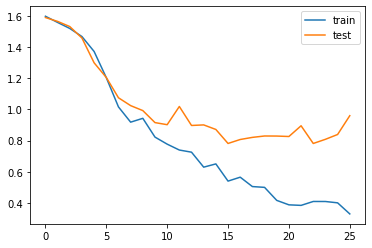

[[210   6  37   7  43]
 [ 44 324  18  17  29]
 [ 24   4 382   3  20]
 [ 18  34   9 251   4]
 [ 84  14  53   4 280]]
              precision    recall  f1-score   support

           0       0.55      0.69      0.61       303
           1       0.85      0.75      0.80       432
           2       0.77      0.88      0.82       433
           3       0.89      0.79      0.84       316
           4       0.74      0.64      0.69       435

    accuracy                           0.75      1919
   macro avg       0.76      0.75      0.75      1919
weighted avg       0.77      0.75      0.76      1919

accuracy_score:  0.7540385617509119


In [23]:
y_val_pop = [np.argmax(y) for y in y_val] # cyfry od 1 do 5

print("Rozmiar danych treningowych: ", len(x_trs))
model = getModel()

metric = 'val_accuracy'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint("./best_model_4A_newModel.hdf5", monitor=metric, verbose=1, save_best_only=True, mode='max')

# Trening i testowaie na zbiorze walidacyjnym:
history=model.fit(x_trs, y_trs, epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

# Wykres diagnostyczny"
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Ładujemy najlepszy zapamiętany model:
model=load_model("best_model_4A_newModel.hdf5")

predicted = [predictLabel(x, model) for x in x_val]

cm = confusion_matrix(y_val_pop, predicted)
print(cm)
print(classification_report(y_val_pop, predicted))
print("accuracy_score: ", accuracy_score(y_val_pop, predicted))

**Transfer learning (w wykorzystaniem modelu z zadania na dst)**

Zamrożenie warstw konwolucyjnych:

In [24]:
for l in best_model_for_dst1.layers[:]:
    if isinstance(l, Conv1D):
        l.trainable = False


Rozmiar danych treningowych:  1000
Epoch 1/80
32/32 [==============================] - 1s 26ms/step - loss: 2.5414 - accuracy: 0.1950 - val_loss: 1.6185 - val_accuracy: 0.2355

Epoch 00001: val_accuracy improved from -inf to 0.23554, saving model to ./best_model_4A_fromDst.hdf5
Epoch 2/80
32/32 [==============================] - 1s 17ms/step - loss: 1.5898 - accuracy: 0.2390 - val_loss: 1.5715 - val_accuracy: 0.2939

Epoch 00002: val_accuracy improved from 0.23554 to 0.29390, saving model to ./best_model_4A_fromDst.hdf5
Epoch 3/80
32/32 [==============================] - 0s 15ms/step - loss: 1.5078 - accuracy: 0.3420 - val_loss: 1.4463 - val_accuracy: 0.4158

Epoch 00003: val_accuracy improved from 0.29390 to 0.41584, saving model to ./best_model_4A_fromDst.hdf5
Epoch 4/80
32/32 [==============================] - 0s 16ms/step - loss: 1.4002 - accuracy: 0.4080 - val_loss: 1.3463 - val_accuracy: 0.4622

Epoch 00004: val_accuracy improved from 0.41584 to 0.46222, saving model to ./best_mo

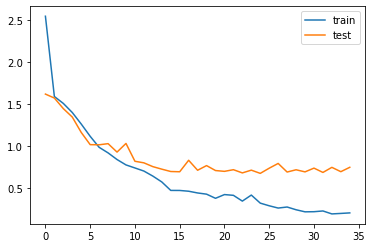

[[227  17  14   6  39]
 [ 19 351   8  20  34]
 [ 14  10 373   7  29]
 [  6  40   8 254   8]
 [ 21  32  28   5 349]]
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       303
           1       0.78      0.81      0.80       432
           2       0.87      0.86      0.86       433
           3       0.87      0.80      0.84       316
           4       0.76      0.80      0.78       435

    accuracy                           0.81      1919
   macro avg       0.81      0.81      0.81      1919
weighted avg       0.81      0.81      0.81      1919

accuracy_score:  0.8097967691505993


In [31]:
y_val_pop = [np.argmax(y) for y in y_val] # cyfry od 1 do 5

print("Rozmiar danych treningowych: ", len(x_trs))

metric = 'val_accuracy'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint('./best_model_4A_fromDst.hdf5', monitor=metric, verbose=1, save_best_only=True, mode='max')

# Trening i testowaie na zbiorze walidacyjnym:
history = best_model_for_dst1.fit(x_trs, y_trs, epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

# Wykres diagnostyczny"
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Ładujemy najlepszy zapamiętany model:
model = load_model('best_model_4A_fromDst.hdf5')

predicted = [predictLabel(x, model) for x in x_val]

cm = confusion_matrix(y_val_pop, predicted)
print(cm)
print(classification_report(y_val_pop, predicted))
print("accuracy_score: ", accuracy_score(y_val_pop, predicted))

##Wnioski do zadania na db (A)

**Dla modelu wytrenowanego od nowa** (dla porównania), wytrenowanego na zbiorze treningowym o liczebności 1000, otrzymaliśmy:
*accuracy_score:  0.7540385617509119*.

**Przypadek przy zastosowaniu transfer learning do treningu** (dla organiczonego zbioru treningowego). Wybraliśmy pięć innych poleceń niż w zadaniu na dst oraz niewielką liczbę nagrań do zbioru treningowego - 1000 (skuteczność klasyfikacji dla tej liczby nie jest oszałamiająco dobra (ok. 67%)). Wytrenowaliśmy model do rozpoznawania nowych pięciu poleceń w oparciu o ograniczony zbiór treningowy. Otrzymaliśmy wynik: *accuracy_score: 0.8097967691505993*.

**Wnioski:** Przy użyciu transfer learningu uzyskany wynik jest lepszy niż w przypadku trenowania modelu. A więc bardziej opłaca się użycie już wytrenowanego modelu i dotrenowanie do do rozpoznawaniu innych słów niż trenować model od nowa. 

# Zadanie na bdb

Zaproponować metody augmentacji danych 1D i sprawdzić, w jaki sposób zastosowania data augmentation wpływa na skuteczność klasyfikacji w przypadku małego zbioru danych. Proszę w tym zadaniu nie używać metod transfer learning - należy wytrenować sieć "from scratch" raz z użyciem data augmentation i raz bez użycia data augmentation dla pięciu słów z zadania na db po czym porównać wyniki.

In [119]:
from sklearn.model_selection import train_test_split

labels = ["cat", "five", "stop", "marvin", "left"]
all_wave, y, classes = data_preprocessing(labels)

x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave), np.array(y), stratify=y, test_size = 0.2, random_state=555, shuffle=True)

x_trs = x_tr[0:1000]
y_trs = y_tr[0:1000]
numberOfTrainingElements = 1000


cat
five
stop
marvin
left


**Wytrenowanie modelu od nowa** (bez augmentacji), dla porównania:

Rozmiar danych treningowych:  1000
Epoch 1/80
32/32 [==============================] - 2s 24ms/step - loss: 1.6075 - accuracy: 0.2339 - val_loss: 1.5917 - val_accuracy: 0.2668

Epoch 00001: val_accuracy improved from -inf to 0.26681, saving model to ./best_model_5_newModel.hdf5
Epoch 2/80
32/32 [==============================] - 0s 16ms/step - loss: 1.5624 - accuracy: 0.3140 - val_loss: 1.5665 - val_accuracy: 0.3116

Epoch 00002: val_accuracy improved from 0.26681 to 0.31162, saving model to ./best_model_5_newModel.hdf5
Epoch 3/80
32/32 [==============================] - 0s 15ms/step - loss: 1.5399 - accuracy: 0.2999 - val_loss: 1.5378 - val_accuracy: 0.3278

Epoch 00003: val_accuracy improved from 0.31162 to 0.32777, saving model to ./best_model_5_newModel.hdf5
Epoch 4/80
32/32 [==============================] - 0s 15ms/step - loss: 1.4971 - accuracy: 0.3566 - val_loss: 1.4965 - val_accuracy: 0.3544

Epoch 00004: val_accuracy improved from 0.32777 to 0.35435, saving model to ./best_mo

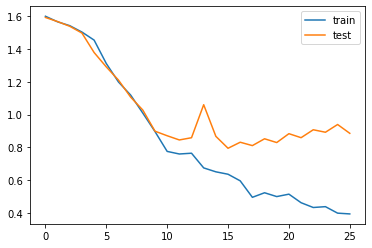

[[104  29  39   2 129]
 [ 28 345  19  15  25]
 [  5   6 395   2  25]
 [  8  50  11 240   7]
 [ 66  31  41   2 295]]
              precision    recall  f1-score   support

           0       0.49      0.34      0.40       303
           1       0.75      0.80      0.77       432
           2       0.78      0.91      0.84       433
           3       0.92      0.76      0.83       316
           4       0.61      0.68      0.64       435

    accuracy                           0.72      1919
   macro avg       0.71      0.70      0.70      1919
weighted avg       0.71      0.72      0.71      1919

accuracy_score:  0.7186034392912976


In [93]:
y_val_pop = [np.argmax(y) for y in y_val] # cyfry od 1 do 5

print("Rozmiar danych treningowych: ", len(x_trs))
model = getModel()

metric = 'val_accuracy'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint("./best_model_5_newModel.hdf5", monitor=metric, verbose=1, save_best_only=True, mode='max')

# Trening i testowaie na zbiorze walidacyjnym:
history=model.fit(x_trs, y_trs, epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

# Wykres diagnostyczny"
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Ładujemy najlepszy zapamiętany model:
model=load_model("best_model_5_newModel.hdf5")

predicted = [predictLabel(x, model) for x in x_val]

cm = confusion_matrix(y_val_pop, predicted)
print(cm)
print(classification_report(y_val_pop, predicted))
print("accuracy_score: ", accuracy_score(y_val_pop, predicted))

###Augumentacja:

In [120]:
print(x_trs.shape)
ipd.Audio(np.squeeze(x_trs[0]), rate=8000)

(1000, 8000, 1)


In [121]:
background_noise_path = "./input/train/audio/_background_noise_"

all_wave_5 = []
waves = [f for f in os.listdir(background_noise_path) if f.endswith('.wav')]
for wav in waves:
    samples, sample_rate = librosa.load(background_noise_path + '/' + wav)
    # sample_rate, samples = wavfile.read(background_noise_path + '/' + wav)
    samples = librosa.resample(samples, sample_rate, 8000)
    samples = samples[0:8000]
    all_wave_5.append(samples)

all_wave_5 = np.array(all_wave_5).reshape((-1, 8000, 1)) # (X,8000) -> (X, 8000, 1)
print(np.array(all_wave_5).shape)
ipd.Audio(np.squeeze(all_wave_5[0]), rate=8000)


(6, 8000, 1)


In [138]:
noised_x = [x for x in x_trs]

for i in range(len(all_wave_5)):
  for j in range(len(x_trs)):
    noised_x[j] = noised_x[j] + all_wave_5[i] * 0.1

for x in x_trs:
  noised_x.append(x) 
noised_y = [y for z in range(2) for y in y_trs]

(1000, 8000, 1)
(2000, 8000, 1)
(2000, 5)


**Trenowanie modelu dla danych po augementacji**:

Rozmiar danych treningowych:  1000
Epoch 1/80
63/63 [==============================] - 2s 15ms/step - loss: 1.5990 - accuracy: 0.2471 - val_loss: 1.5839 - val_accuracy: 0.2720

Epoch 00001: val_accuracy improved from -inf to 0.27202, saving model to ./best_model_5_aug.hdf5
Epoch 2/80
63/63 [==============================] - 1s 11ms/step - loss: 1.5591 - accuracy: 0.2999 - val_loss: 1.5472 - val_accuracy: 0.3090

Epoch 00002: val_accuracy improved from 0.27202 to 0.30902, saving model to ./best_model_5_aug.hdf5
Epoch 3/80
63/63 [==============================] - 1s 11ms/step - loss: 1.5306 - accuracy: 0.3355 - val_loss: 1.5753 - val_accuracy: 0.2788

Epoch 00003: val_accuracy did not improve from 0.30902
Epoch 4/80
63/63 [==============================] - 1s 11ms/step - loss: 1.4658 - accuracy: 0.3632 - val_loss: 1.3890 - val_accuracy: 0.4153

Epoch 00004: val_accuracy improved from 0.30902 to 0.41532, saving model to ./best_model_5_aug.hdf5
Epoch 5/80
63/63 [===========================

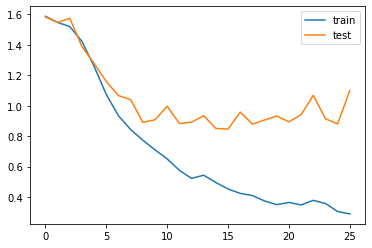

[[186  13  21   5  78]
 [ 27 330  11  26  38]
 [ 37   1 349   7  39]
 [ 11  36   2 254  13]
 [ 35  21  31   1 347]]
              precision    recall  f1-score   support

           0       0.63      0.61      0.62       303
           1       0.82      0.76      0.79       432
           2       0.84      0.81      0.82       433
           3       0.87      0.80      0.83       316
           4       0.67      0.80      0.73       435

    accuracy                           0.76      1919
   macro avg       0.77      0.76      0.76      1919
weighted avg       0.77      0.76      0.77      1919

accuracy_score:  0.7639395518499218


In [139]:
y_val_pop = [np.argmax(y) for y in y_val] # cyfry od 1 do 5

print("Rozmiar danych treningowych: ", len(noised_x))
model = getModel()

metric = 'val_accuracy'
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint("./best_model_5_aug.hdf5", monitor=metric, verbose=1, save_best_only=True, mode='max')

# Trening i testowaie na zbiorze walidacyjnym:
history=model.fit(np.array(noised_x), np.array(noised_y), epochs=80, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

# Wykres diagnostyczny"
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Ładujemy najlepszy zapamiętany model:
model=load_model("best_model_5_aug.hdf5")

predicted = [predictLabel(x, model) for x in x_val]

cm = confusion_matrix(y_val_pop, predicted)
print(cm)
print(classification_report(y_val_pop, predicted))
print("accuracy_score: ", accuracy_score(y_val_pop, predicted))

**Sposób augumentacji:** Dokonaliśmy augumentacji poprzez dodanie *background noises* (dane z tego samego folderu co dane innych próbek).

**Wnioski:** Dla modelu wytrenownego od początku, bez augmentacji, otrzymaliśmy *accuracy_score:  0.7186034392912976* - dla zbioru o liczebności 1000. Po dodaniu danych po augumentacji i wytrenowaniu modelu od nowa otrzymaliśmy: *accuracy_score:  0.7639395518499218*. Więc rzeczywiście widać, że ta technika jest pomocna przy małych zbiorach danych - dokładność została polepszona. 
